In [3]:
import os
import ast
import pandas as pd
from langchain.schema import Document
from langchain.llms import Anthropic
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains.question_answering import load_qa_chain

# Get Data

This is a corpus of questions from Mendable.

In [4]:
# Read
d=pd.read_csv("data/langchain_data_may15_may30.csv")
# List
d['messages_unpack'] = d['messages'].apply(lambda x: ast.literal_eval(x))
d['messages_first'] = d['messages_unpack'].apply(lambda x: x[0])
# Flatten the list of lists and convert to lowercase
combined_messages = [msg.lower() for sublist in d['messages_unpack'] for msg in sublist]
first_messages = [msg.lower() for msg in d['messages_first']]
# Remove duplicates without preserving order 
unique_messages = list(set(combined_messages))
unique_messages_first = list(set(first_messages))
print("Total questions: ", len(unique_messages))
print("Total first questions: ", len(unique_messages_first))
# Count total characters and estimate tokens
total_chars = sum(len(question) for question in unique_messages)
total_chars_first = sum(len(question) for question in unique_messages_first)
print("Total characters: ", total_chars)
print("Total tokens: ", total_chars/4)
print("Total characters first message: ", total_chars_first)
print("Total tokens first message: ", total_chars_first/4)

Total questions:  29918
Total first questions:  16437
Total characters:  2787040
Total tokens:  696760.0
Total characters first message:  1378474
Total tokens first message:  344618.5


In [5]:
remove_strings=["what is a prompt template?","how to cache llm calls?"]
filtered_unique_messages_first = [s for s in unique_messages_first if s not in remove_strings]
len(filtered_unique_messages_first)

16435

Useful function for list splitting.

In [177]:
def split_into_sublists(lst, max_tokens=100000):
    
    """ Split a list of strings (questions) into sub-lists where 
        each sub-list has less than a specified token count """
    
    sublists = []
    sublist = []
    tokens_in_sublist = 0
    question_number = 1  # Initialize the question number

    for question in lst:
        
        # This is needed in the prompt for the LLM to treat questions as a list
        question = f"{question_number}. {question}"  # Append the question number
        
        # Estimate the number of tokens
        tokens_in_question = len(question) // 4  
        if tokens_in_sublist + tokens_in_question > max_tokens:
            # Start a new sublist
            sublists.append(sublist)
            sublist = [question]
            tokens_in_sublist = tokens_in_question
        else:
            # Add to current sublist
            sublist.append(question)
            tokens_in_sublist += tokens_in_question
        question_number += 1  # Increment the question number
    
    # Add the last sublist if it's not empty
    if sublist:
        sublists.append(sublist)

    return sublists

# Test a Map-Reduce style flow 

* Split the list of questions into N sub-lists
* Map each sub-list into a summary
* Reduce the summaries into a final summary

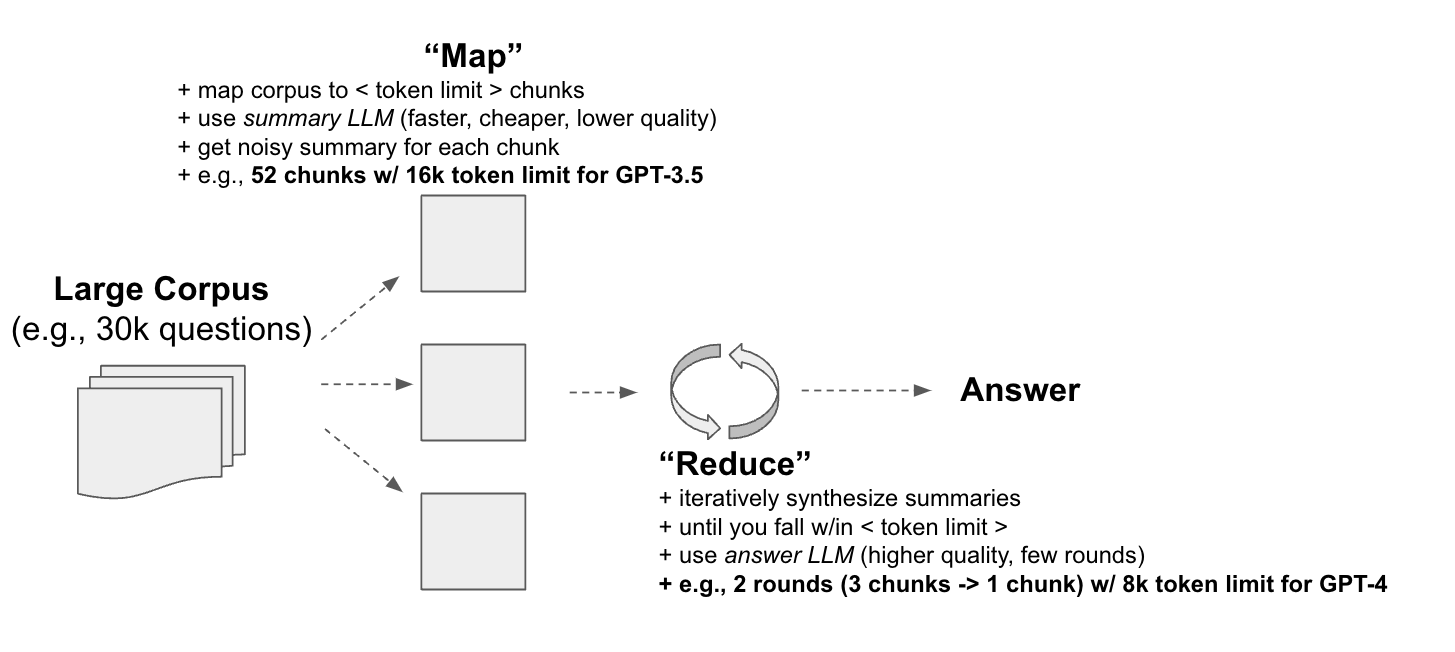

# Map

* Map list of `questions` to a list of `summaries`, where each set of questions is summarized.
* We break up the list of questions into sub-lists that each fit into an LLM for summarization.
* Best results w/ `gpt-3.5-turbo-16k`

In [152]:
# Summary LLM

# Problems w/ Anthropic (API usage limits and slow)
"""
os.environ['ANTHROPIC_API_KEY'] = 'xxx'
from langchain.llms import Anthropic
llm = Anthropic(model="claude-v1-100k",temperature=0)
"""
# Use `GPT3.5-Turbo-16k` for the first pass 
# it's fast, but of course results are bit noisy
llm = ChatOpenAI(model_name="gpt-3.5-turbo-16k", temperature=0)

# Break up questions into chunks to summarize
# 14000 so that we have some headroom for the remainder of the prompt (16000 token model)
summary_llm_token_limit=14000
question_lists=split_into_sublists(unique_messages,max_tokens=summary_llm_token_limit)

# Summary prompt
template = """{question}
{context}

Based on this list of questions, please do 3 things: 
(1) identify the main themes 
(2) give a represntitive example question in each theme
(3) estimate the proportion of questions that fall into each theme

Helpful Answer:"""
SUMMARY_QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"],template=template)
qa_chain = load_qa_chain(llm,chain_type="stuff",prompt=SUMMARY_QA_CHAIN_PROMPT)

# Test w/ one list
docs=[Document(page_content=str(question_lists[0]))]
question = "The following is a list of questions, commands, and keyords that have been entered into a Q+A system:"
answer=qa_chain.run(input_documents=docs,question=question)
answer

'(1) Main Themes:\n- Setup and configuration: Questions related to setting up and configuring various components of the langchain system.\n- Model and LLM usage: Questions about using different models and language models (LLMs) in langchain.\n- Tools and memory: Questions about using tools and memory in langchain.\n- Prompt and template usage: Questions about using prompts and templates in langchain.\n- Data loading and processing: Questions related to loading and processing data in langchain.\n- Agent and chain usage: Questions about creating and using agents and chains in langchain.\n- Embeddings and vector stores: Questions about using embeddings and vector stores in langchain.\n- Error handling and troubleshooting: Questions related to handling errors and troubleshooting issues in langchain.\n- Language and localization: Questions about language support and localization in langchain.\n- Miscellaneous: Questions that do not fit into any specific theme.\n\n(2) Representative Example 

In [ ]:
# Summarize each chunk of questions
summaries = []
for i,sublist in enumerate(question_lists):
    print("--- --- ---")
    print("Sample: ", i+1)
    docs=[Document(page_content=str(sublist))]
    try:
        answer=qa_chain.run(input_documents=docs,question=question)
    except:
        print("Error (InvalidRequestError) on sample: ", i+1)
    # print(answer)
    summaries.append(answer)

# Reduce:

* Reduce the list of summaries into a final summary
* Use a higher capacity model for this
* Best results w/ `gpt-4`

In [176]:
# Answer LLM
# os.environ['ANTHROPIC_API_KEY'] = 'xxx'
# llm = Anthropic(model="claude-v1-100k",temperature=0)
llm = ChatOpenAI(model_name="gpt-4", temperature=0)

# Leave headroom for prompt under 8100 token limit
refine_llm_token_limit=7000
answer_lists=split_into_sublists(answers,max_tokens=refine_llm_token_limit)

# Refine prompt
template = """{question}

Here is the list of summaries:
{context}

Take these and distill it into a final, consolidated list with: 
(1) the main question themes 
(2) two represntitive example questions in each theme
(3) estimate the proportion of questions that fall into each theme

Helpful Answer:"""
REFINE_QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"],template=template)
qa_chain = load_qa_chain(llm,chain_type="stuff",prompt=REFINE_QA_CHAIN_PROMPT)

# Refine
# To Do: Recursivly run until you have a list w/ single answer
answers_refined = []
for i,sublist in enumerate(answer_lists):
    print("--- --- ---")
    print("Sample: ", i+1)
    docs=[Document(page_content=str(sublist))]
    try:
        answer=qa_chain.run(input_documents=docs,question=question)
    except:
        print("Error (InvalidRequestError) on sample: ", i+1)
    # print(answer)
    answers_refined.append(answer)
    
# Above results in 3 docs, so run once more to produce final answer (note: this should be automated)
docs=[Document(page_content=str(answers_refined))]
answer_final=qa_chain.run(input_documents=docs,question=question)
answer_final

'(1) Main Question Themes:\n1. Setup, Configuration, and Implementation\n2. Functionality, Features, and Usage\n3. Integration, Compatibility, and External Tools\n4. Data Handling, Processing, and Manipulation\n5. Language Model (LLM) Usage and Model-Specific Questions\n6. Prompt Engineering and Agent/Chain Configuration\n7. Error Handling, Debugging, and Troubleshooting\n8. Language Support, Localization, and Translation\n9. Memory Management and Conversation Management\n10. Deployment, Production, and Application Development\n\n(2) Representative Example Questions:\n1. Setup, Configuration, and Implementation: \n   - "How can I set up agentexecutor.from_agent_and_tools to have combined memory of vectorstoreretrievermemory and conversationsummarymemory?"\n   - "How do I use Langchain to create a chatbot based on a CSV file?"\n2. Functionality, Features, and Usage: \n   - "How does langchain handle context length?"\n   - "How do I add metadata to documents in Langchain?"\n3. Integratio

# Deep Dive

We can also reduce to a specific set of questions on a given theme.

On `Data Handling, Processing, and Manipulation`

In [178]:
# Refine prompt
template = """{question}

Here is the list of summaries:
{context}

Take these and distill it into a final, consolidated list with: 
(1) the top 10 question related to "Data Handling, Processing, and Manipulation"
(2) estimate the proportion of each question

Helpful Answer:"""
REFINE_QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context", "question"],template=template)
qa_chain = load_qa_chain(llm,chain_type="stuff",prompt=REFINE_QA_CHAIN_PROMPT)

question = "The following is a list of summaries of questions in a Q+A system. We want to focus on Data Handling, Processing, and Manipulation"

# Refine
# To Do: Recursivly run until you have a list w/ single answer
answers_refined_data = []
for i,sublist in enumerate(answer_lists):
    print("--- --- ---")
    print("Sample: ", i+1)
    docs=[Document(page_content=str(sublist))]
    try:
        answer=qa_chain.run(input_documents=docs,question=question)
    except:
        print("Error (InvalidRequestError) on sample: ", i+1)
    # print(answer)
    answers_refined_data.append(answer)
    
# Above results in 3 docs, so run once more to produce final answer (note: this should be automated)
docs=[Document(page_content=str(answers_refined_data))]
answer_final_data=qa_chain.run(input_documents=docs,question=question)
answer_final_data

--- --- ---
Sample:  1
--- --- ---
Sample:  2
--- --- ---
Sample:  3


'Based on the summaries provided, here is a consolidated list of the top 10 questions related to "Data Handling, Processing, and Manipulation" along with their estimated proportions:\n\n1. Loading and processing CSV files:\n   - Example question: "How can I process and summarize data from a CSV file using Langchain?"\n   - Proportion: 15%\n\n2. File handling and data loading:\n   - Example question: "How can I read a file from S3 and load it into Langchain?"\n   - Proportion: 10%\n\n3. Loading and processing PDF files:\n   - Example question: "How do I load and split PDF files using the text_splitter in Langchain?"\n   - Proportion: 12%\n\n4. Loading and processing text documents:\n   - Example question: "How do I load documents from text files and process them using Langchain?"\n   - Proportion: 10%\n\n5. Handling long prompts and documents:\n   - Example question: "How can I handle long prompts that are too long for GPT-4?"\n   - Proportion: 10%\n\n6. Reading files from a folder for 